In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set the seaborn style - options include 'whitegrid', 'darkgrid', 'white', 'dark', 'ticks'
sns.set_theme(style='whitegrid') 
sns.color_palette("hls", 8)

# Set the context - options include 'paper', 'notebook', 'talk', 'poster'
sns.set_context("notebook", font_scale=1.2)  # Slightly larger text for better readability

# Set a custom color palette (optional)
custom_palette = sns.color_palette("Set2")
sns.set_palette(custom_palette)

# For matplotlib, you can also set a style
plt.style.use('seaborn-v0_8-whitegrid')  # Use a Seaborn style in matplotlib

In [27]:
def setup_gpu_acceleration():
    """Set up GPU acceleration based on available hardware."""
    import platform
    import os
    
    # Initialize variables
    use_gpu = False
    gpu_type = None
    tree_method = "hist"  # Default CPU method for tree-based models
    
    # Check for CUDA (NVIDIA GPUs)
    try:
        import torch
        if torch.cuda.is_available():
            use_gpu = True
            gpu_type = "CUDA"
            tree_method = "gpu_hist"
            n_gpus = torch.cuda.device_count()
            gpu_name = torch.cuda.get_device_name(0)
            print(f"✅ CUDA GPU detected: {gpu_name} ({n_gpus} device(s))")
    except ImportError:
        pass
        
    # If CUDA not found, check for Mac MPS (Apple Silicon/Metal)
    if not use_gpu and platform.system() == "Darwin":  # Darwin = macOS
        try:
            # Check if Mac has Apple Silicon
            is_apple_silicon = platform.processor() == 'arm' or 'Apple M' in os.popen('sysctl -n machdep.cpu.brand_string').read()
            
            if is_apple_silicon:
                use_gpu = True
                gpu_type = "MPS"
                tree_method = "gpu_hist"  # For tree-based models that support Metal
                print("✅ Apple Silicon GPU detected")
                
                # Set Metal-specific environment variables if needed
                os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
        except:
            pass
    
    if not use_gpu:
        print("⚠️ No compatible GPU detected. Using CPU only.")
    
    return {
        "use_gpu": use_gpu,
        "gpu_type": gpu_type,
        "tree_method": tree_method,
        "device": "cuda" if gpu_type == "CUDA" else "mps" if gpu_type == "MPS" else "cpu"
    }

# Run the setup
gpu_config = setup_gpu_acceleration()

# Usage examples (for reference):
# 
# 1. For XGBoost:
# xgb_model = xgb.XGBClassifier(
#     tree_method=gpu_config["tree_method"],
#     ...other parameters...
# )
#
# 2. For PyTorch models (including TabNet):
# device = torch.device(gpu_config["device"])
# model = Model(...).to(device)

✅ Apple Silicon GPU detected


In [28]:
raw_data = pd.read_csv('../raw_data/AirlinePassengerSatisfaction.csv')

# change the unnamed column to 'index'
raw_data.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

raw_data.head()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [29]:
# Check for missing values
missing_values = raw_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in the dataset:")
print(missing_values)



Missing values in the dataset:
Arrival Delay in Minutes    83
dtype: int64


In [30]:
# remove the rows with missing values
raw_data.dropna(inplace=True)

# show the size of the dataset
print("Size of the dataset after removing missing values:")
print(raw_data.shape)

Size of the dataset after removing missing values:
(25893, 25)


In [31]:
# Check for duplicate rows
duplicate_rows = raw_data[raw_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")


Number of duplicate rows: 0


/var/folders/hv/1ymrtwbx65590wt4nm4gwphw0000gn/T/ipykernel_66313/4050473522.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='satisfaction', data=raw_data, palette=['red', 'green'])


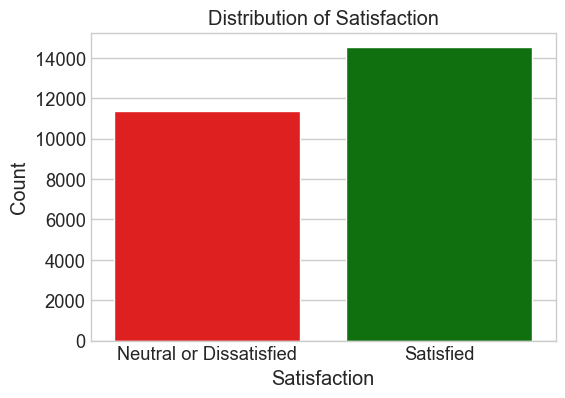

In [32]:
# visualize the distribution of the satisfaction using seaborn

plt.figure(figsize=(6, 4))
sns.countplot(x='satisfaction', data=raw_data, palette=['red', 'green'])
plt.title('Distribution of Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('Count')
# Set the labels for the x-axis
plt.xticks([0, 1], ['Neutral or Dissatisfied', 'Satisfied'])
plt.show()

In [33]:
raw_data = pd.read_csv('../data/airline_passenger_satisfaction.csv')
raw_data.head()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,satisfaction_encoded,Gender_encode,Customer_Type_encode,Travel_Type_encode,Class_Eco,Class_Business,Class_Eco_Plus
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,50,44.0,satisfied,1,0,1,1,1,0,0
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,0,0.0,satisfied,1,0,1,1,0,1,0
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,0,0.0,neutral or dissatisfied,0,1,0,1,1,0,0
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,0,6.0,satisfied,1,1,1,1,0,1,0
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,0,20.0,satisfied,1,0,1,1,1,0,0


In [34]:
print(raw_data['satisfaction'].unique())
# convert the satisfaction column to 0 and 1
raw_data['satisfaction_encoded'] = raw_data['satisfaction'].map({
    'neutral or dissatisfied': 0, 
    'satisfied': 1
})

# Verify the conversion
print(raw_data[['satisfaction', 'satisfaction_encoded']].head())

['satisfied' 'neutral or dissatisfied']
              satisfaction  satisfaction_encoded
0                satisfied                     1
1                satisfied                     1
2  neutral or dissatisfied                     0
3                satisfied                     1
4                satisfied                     1


In [35]:
# print(raw_data.dtypes)
'''
index                                  int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfaction                          object
satisfaction_encoded                   int64
dtype: object
'''


'\nindex                                  int64\nid                                     int64\nGender                                object\nCustomer Type                         object\nAge                                    int64\nType of Travel                        object\nClass                                 object\nFlight Distance                        int64\nInflight wifi service                  int64\nDeparture/Arrival time convenient      int64\nEase of Online booking                 int64\nGate location                          int64\nFood and drink                         int64\nOnline boarding                        int64\nSeat comfort                           int64\nInflight entertainment                 int64\nOn-board service                       int64\nLeg room service                       int64\nBaggage handling                       int64\nCheckin service                        int64\nInflight service                       int64\nCleanliness                    

/var/folders/hv/1ymrtwbx65590wt4nm4gwphw0000gn/T/ipykernel_66313/1559368197.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:],


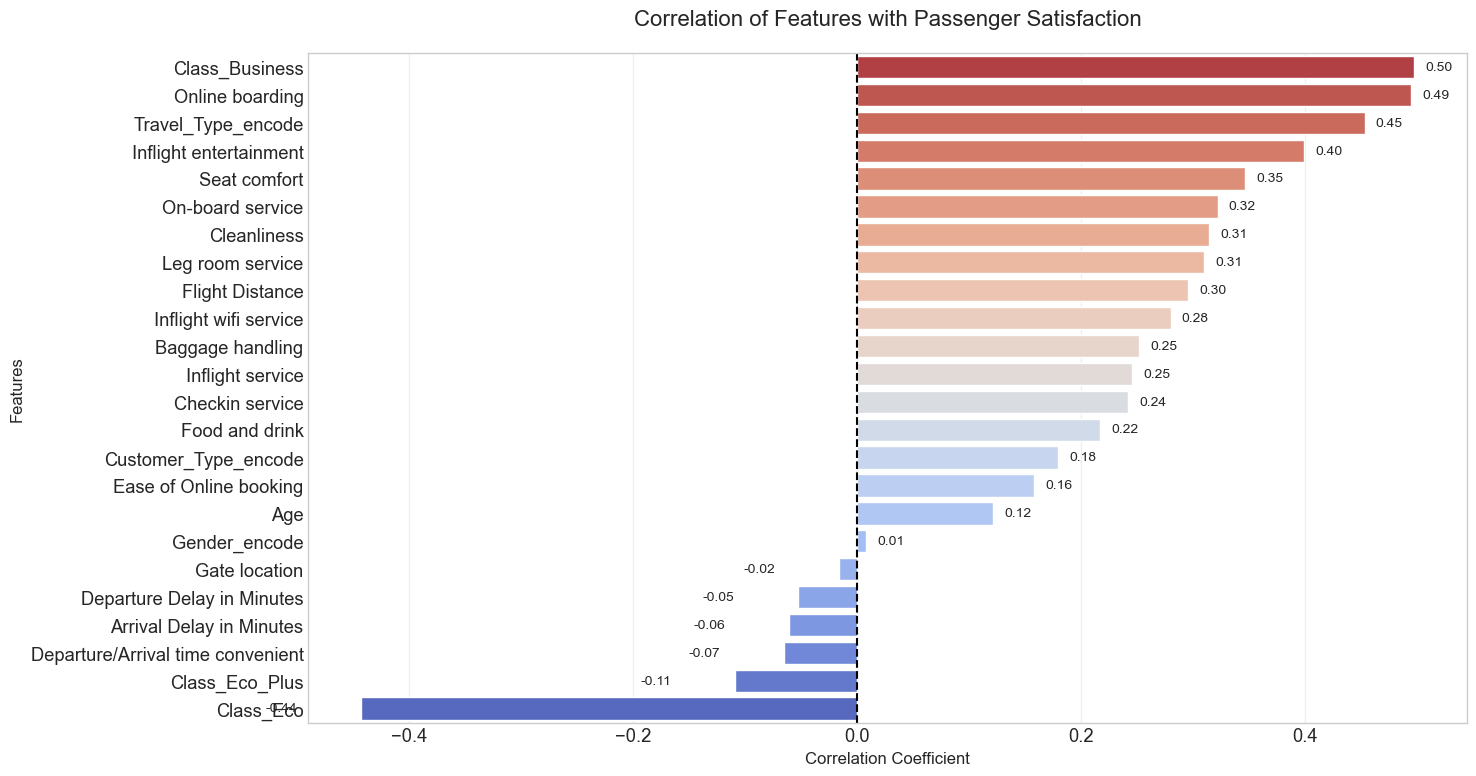

Top 5 most positively correlated features with satisfaction:
Class_Business            0.497237
Online boarding           0.494322
Travel_Type_encode        0.452957
Inflight entertainment    0.398884
Seat comfort              0.346398
Name: satisfaction_encoded, dtype: float64

Top 5 most negatively correlated features with satisfaction:
Departure Delay in Minutes          -0.053042
Arrival Delay in Minutes            -0.061059
Departure/Arrival time convenient   -0.065266
Class_Eco_Plus                      -0.108685
Class_Eco                           -0.442717
Name: satisfaction_encoded, dtype: float64


In [36]:
# Get only numeric columns for correlation analysis, excluding id and index
numeric_cols = raw_data.select_dtypes(include=['int64', 'float64']).columns
cols_to_exclude = ['id', 'index']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Calculate correlation with filtered numeric columns
satisfaction_correlation = raw_data[numeric_cols].corr()['satisfaction_encoded'].sort_values(ascending=False)

# Create a more focused correlation visualization
plt.figure(figsize=(15, 8))

# Create a bar chart of correlations (exclude the target's correlation with itself)
sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:], 
            palette='coolwarm_r')

plt.title('Correlation of Features with Passenger Satisfaction', fontsize=16, pad=20)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)

# Add correlation values as text
for i, v in enumerate(satisfaction_correlation.values[1:]):
    plt.text(v + (0.01 if v >= 0 else -0.085), i, f"{v:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print the top 5 most positively and negatively correlated features
print("Top 5 most positively correlated features with satisfaction:")
print(satisfaction_correlation[1:6])  # Skip satisfaction_encoded itself (index 0)

print("\nTop 5 most negatively correlated features with satisfaction:")
print(satisfaction_correlation[-(5):])

In [37]:
# convert the categorical columns to a new numeric column except the 'satisfaction'
categorical_cols = raw_data.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'satisfaction']

print(categorical_cols)

['Gender', 'Customer Type', 'Type of Travel', 'Class']


In [38]:
print(raw_data['Gender'].unique())
print(raw_data['Customer Type'].unique())
print(raw_data['Type of Travel'].unique())
print(raw_data['Class'].unique())

['Female' 'Male']
['Loyal Customer' 'disloyal Customer']
['Business travel' 'Personal Travel']
['Eco' 'Business' 'Eco Plus']


In [39]:
# Create a copy of the data to avoid modifying the original
data_transformed = raw_data.copy()

# Label encoding for Gender, Customer Type, and Travel Type - creating new columns
data_transformed['Gender_encode'] = data_transformed['Gender'].map({'Female': 0, 'Male': 1})
data_transformed['Customer_Type_encode'] = data_transformed['Customer Type'].map({'disloyal Customer': 0, 'Loyal Customer': 1})
data_transformed['Travel_Type_encode'] = data_transformed['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})

# One-hot encoding for Class
data_transformed['Class_Eco'] = (data_transformed['Class'] == 'Eco').astype(int)
data_transformed['Class_Business'] = (data_transformed['Class'] == 'Business').astype(int)
data_transformed['Class_Eco_Plus'] = (data_transformed['Class'] == 'Eco Plus').astype(int)

# Verify transformations
print("\nTransformed Data Sample:")
cols_to_show = ['Gender', 'Gender_encode', 'Customer Type', 'Customer_Type_encode', 
                'Type of Travel', 'Travel_Type_encode', 'Class', 
                'Class_Eco', 'Class_Business', 'Class_Eco_Plus']
print(data_transformed[cols_to_show].head())

# Check columns were created correctly
print("\nNew encoded columns:")
encoded_cols = [col for col in data_transformed.columns if 
                'encode' in col or col.startswith('Class_')]
print(encoded_cols)


Transformed Data Sample:
   Gender  Gender_encode      Customer Type  Customer_Type_encode  \
0  Female              0     Loyal Customer                     1   
1  Female              0     Loyal Customer                     1   
2    Male              1  disloyal Customer                     0   
3    Male              1     Loyal Customer                     1   
4  Female              0     Loyal Customer                     1   

    Type of Travel  Travel_Type_encode     Class  Class_Eco  Class_Business  \
0  Business travel                   1       Eco          1               0   
1  Business travel                   1  Business          0               1   
2  Business travel                   1       Eco          1               0   
3  Business travel                   1  Business          0               1   
4  Business travel                   1       Eco          1               0   

   Class_Eco_Plus  
0               0  
1               0  
2               0  
3   

/var/folders/hv/1ymrtwbx65590wt4nm4gwphw0000gn/T/ipykernel_66313/4232794210.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:],


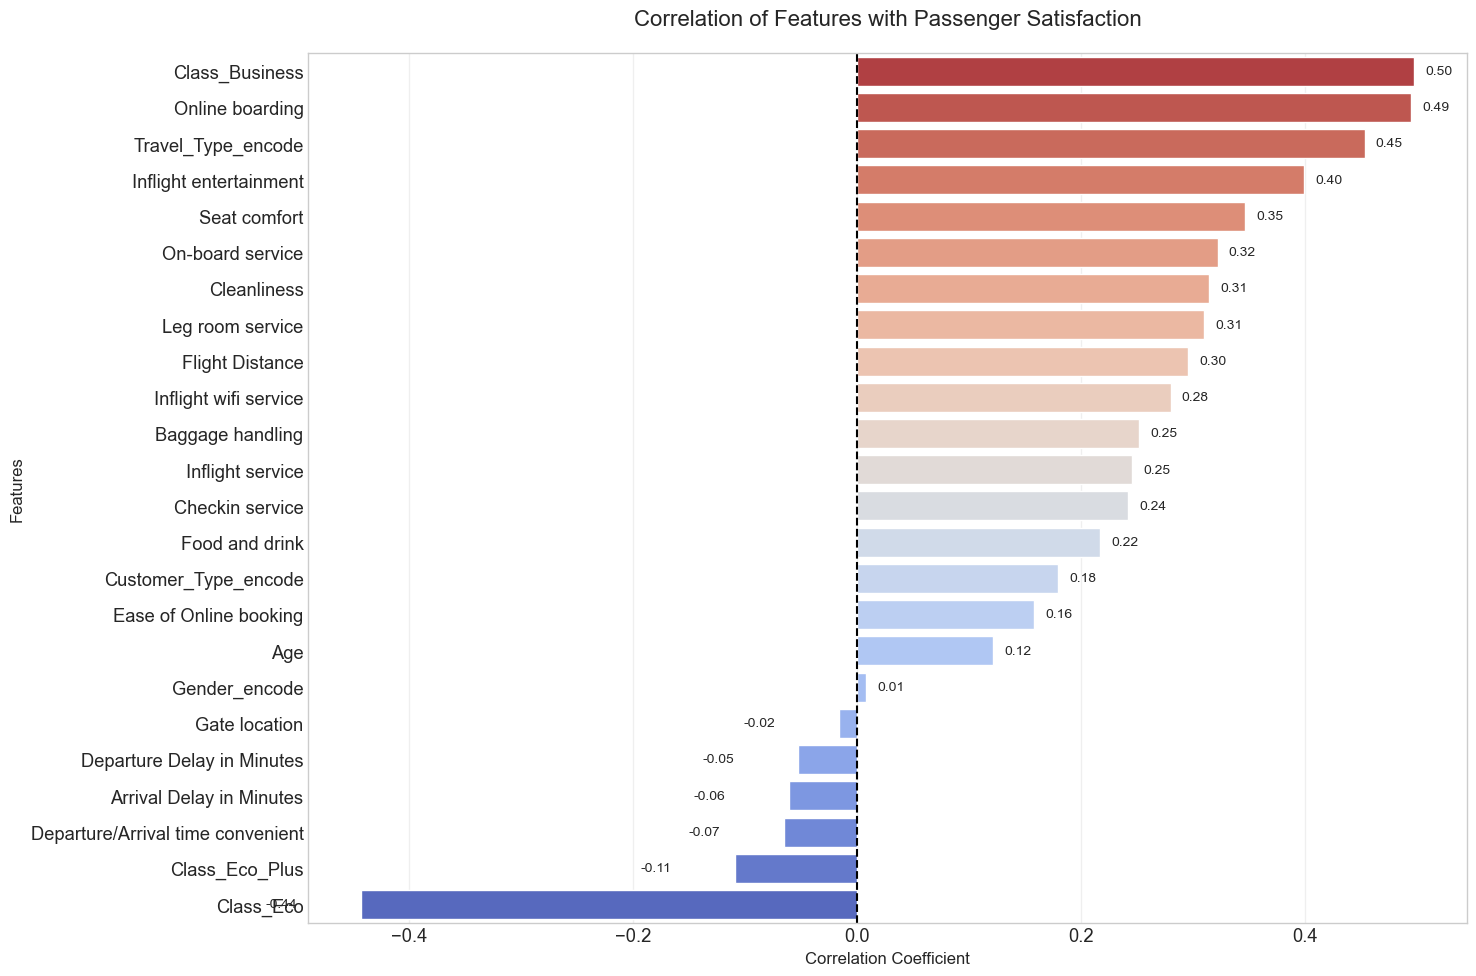


Top 10 correlations with satisfaction:
Class_Business            0.497237
Online boarding           0.494322
Travel_Type_encode        0.452957
Inflight entertainment    0.398884
Seat comfort              0.346398
On-board service          0.321844
Cleanliness               0.314229
Leg room service          0.310092
Flight Distance           0.295352
Inflight wifi service     0.279884
Name: satisfaction_encoded, dtype: float64

Correlations for encoded categorical variables:
satisfaction_encoded    1.000000
Class_Business          0.497237
Travel_Type_encode      0.452957
Customer_Type_encode    0.179482
Gender_encode           0.008052
Class_Eco_Plus         -0.108685
Class_Eco              -0.442717
Name: satisfaction_encoded, dtype: float64


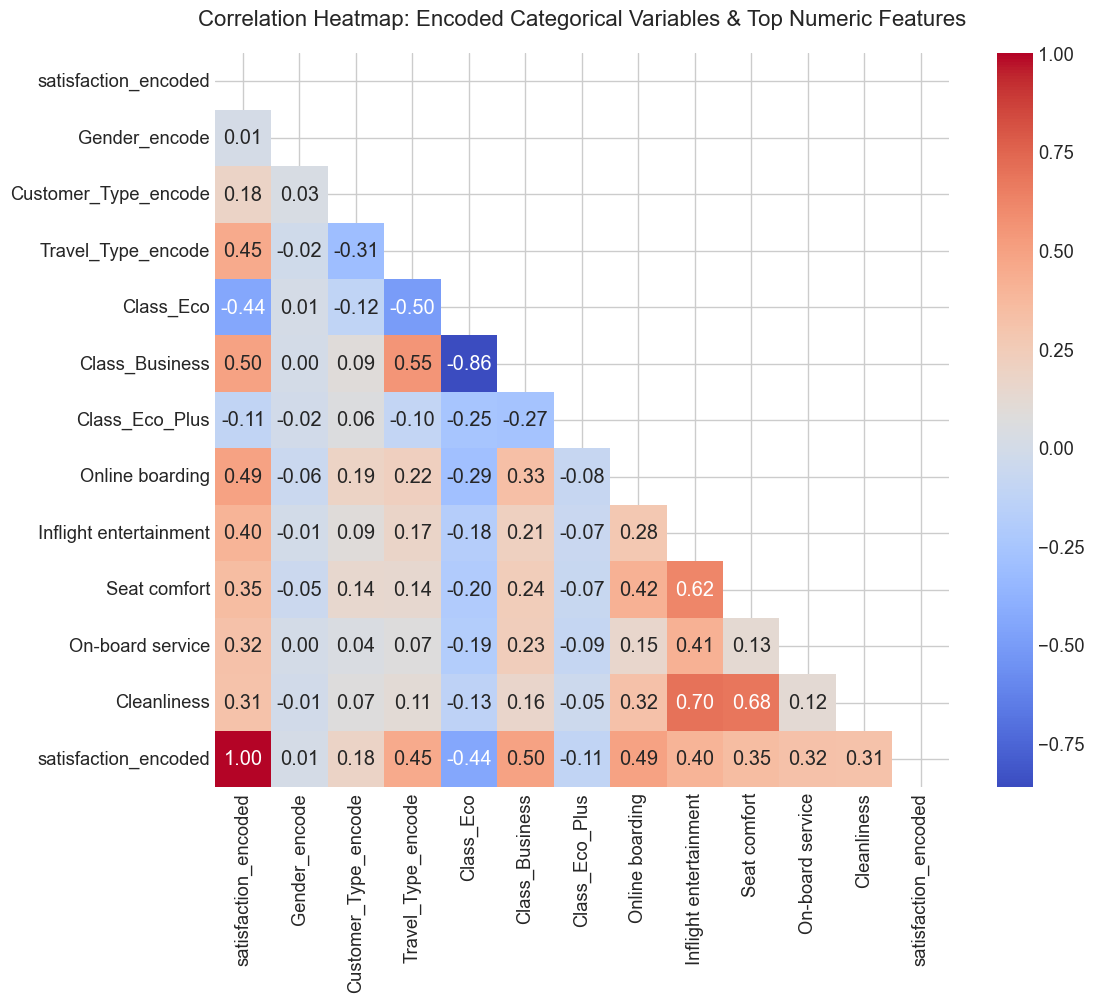

In [40]:
# Get all numeric columns from the transformed dataset
numeric_cols = data_transformed.select_dtypes(include=['int64', 'float64']).columns
cols_to_exclude = ['id', 'index']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Calculate correlation with satisfaction_encoded
satisfaction_correlation = data_transformed[numeric_cols].corr()['satisfaction_encoded'].sort_values(ascending=False)

# Create a more focused correlation visualization
plt.figure(figsize=(15, 10))

# Create a bar chart of correlations (exclude the target's correlation with itself)
sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:], 
            palette='coolwarm_r')

plt.title('Correlation of Features with Passenger Satisfaction', fontsize=16, pad=20)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)

# Add correlation values as text
for i, v in enumerate(satisfaction_correlation.values[1:]):
    plt.text(v + (0.01 if v >= 0 else -0.085), i, f"{v:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print the top correlations, highlighting the encoded categorical variables
print("\nTop 10 correlations with satisfaction:")
print(satisfaction_correlation[1:11])  # Skip satisfaction_encoded itself

print("\nCorrelations for encoded categorical variables:")
cat_vars_corr = satisfaction_correlation.filter(items=encoded_cols)
print(cat_vars_corr.sort_values(ascending=False))

# Create a focused heatmap for the encoded categorical variables plus top numeric features
# Get top 5 numeric features (excluding encoded categoricals and satisfaction)
top_numeric = [col for col in satisfaction_correlation.index[:10] if col not in encoded_cols and col != 'satisfaction_encoded'][:5]
features_to_plot = encoded_cols + top_numeric + ['satisfaction_encoded']

plt.figure(figsize=(12, 10))
corr_subset = data_transformed[features_to_plot].corr()
mask = np.triu(np.ones_like(corr_subset))
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap='coolwarm', square=True, mask=mask)
plt.title('Correlation Heatmap: Encoded Categorical Variables & Top Numeric Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [41]:
# plot the each numeric column with a scatter plot to check if there is any outlier for each column

# for col in numeric_cols:
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x=raw_data['satisfaction_encoded'], y=raw_data[col], alpha=0.5)
#     plt.title(f'Satisfaction vs {col}')
#     plt.xlabel('Satisfaction')
#     plt.ylabel(col)
#     plt.axhline(y=0, color='black', linestyle='--')
#     plt.grid()
#     plt.show()
    

In [42]:
# help me save the remove null values dataset to a csv file under '../data/airline_passenger_satisfaction.csv'
data_transformed.to_csv('../data/airline_passenger_satisfaction.csv', index=False)
print("Dataset saved to '../data/airline_passenger_satisfaction.csv'")


Dataset saved to '../data/airline_passenger_satisfaction.csv'


## XGBoost

In [43]:
# based on the dataset, help me create XGBoost model to predict the satisfaction of the passengers
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve


In [44]:
data_cleaned = pd.read_csv('../data/airline_passenger_satisfaction.csv')

data_cleaned.head()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,satisfaction_encoded,Gender_encode,Customer_Type_encode,Travel_Type_encode,Class_Eco,Class_Business,Class_Eco_Plus
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,50,44.0,satisfied,1,0,1,1,1,0,0
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,0,0.0,satisfied,1,0,1,1,0,1,0
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,0,0.0,neutral or dissatisfied,0,1,0,1,1,0,0
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,0,6.0,satisfied,1,1,1,1,0,1,0
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,0,20.0,satisfied,1,0,1,1,1,0,0


In [45]:
# split the data to train and test
X = data_cleaned.drop(columns=['satisfaction', 'satisfaction_encoded'])
y = data_cleaned['satisfaction_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the predictors which are all numeric columns except the 'index' and 'id' columns
predictors = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove 'index' and 'id' from predictors
predictors = [col for col in predictors if col not in ['index', 'id']]




In [46]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
    # tree_method=gpu_config["tree_method"]  # Use GPU if available
)

# Basic fit without extra parameters
xgb_model.fit(X_train[predictors], y_train)

# Make predictions
y_pred_prob = xgb_model.predict_proba(X_test[predictors])[:, 1]
y_pred = xgb_model.predict(X_test[predictors])

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9575


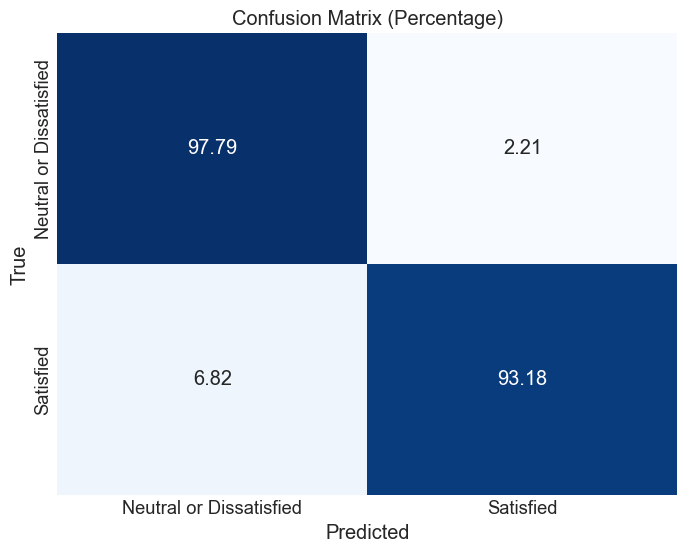

In [47]:
# plot the confusion matrix with the percentage of each class
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False,
                xticklabels=['Neutral or Dissatisfied', 'Satisfied'],
                yticklabels=['Neutral or Dissatisfied', 'Satisfied'])
    plt.title('Confusion Matrix (Percentage)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
plot_confusion_matrix(y_test, y_pred)


<Figure size 1500x800 with 0 Axes>

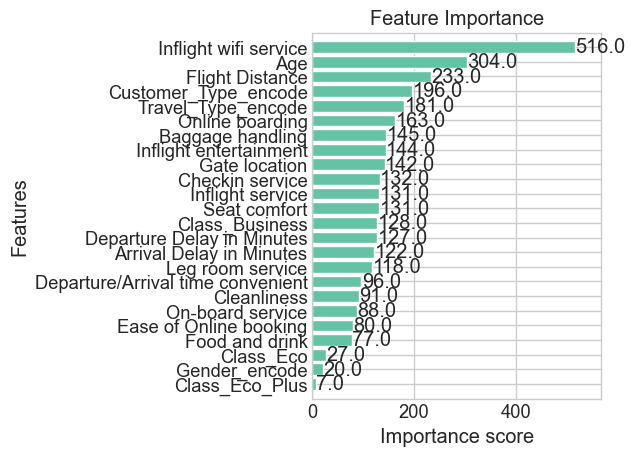

In [48]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(15, 8))
plot_importance(xgb_model, height=0.8, max_num_features=30)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## Random Forest

In [49]:
# use the random forest to predict the satisfaction of the passengers based on the split dataset
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6
)
# Fit the model
rf_model.fit(X_train[predictors], y_train)
# Make predictions
y_pred_rf = rf_model.predict(X_test[predictors])
# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Random Forest Accuracy: 0.9299


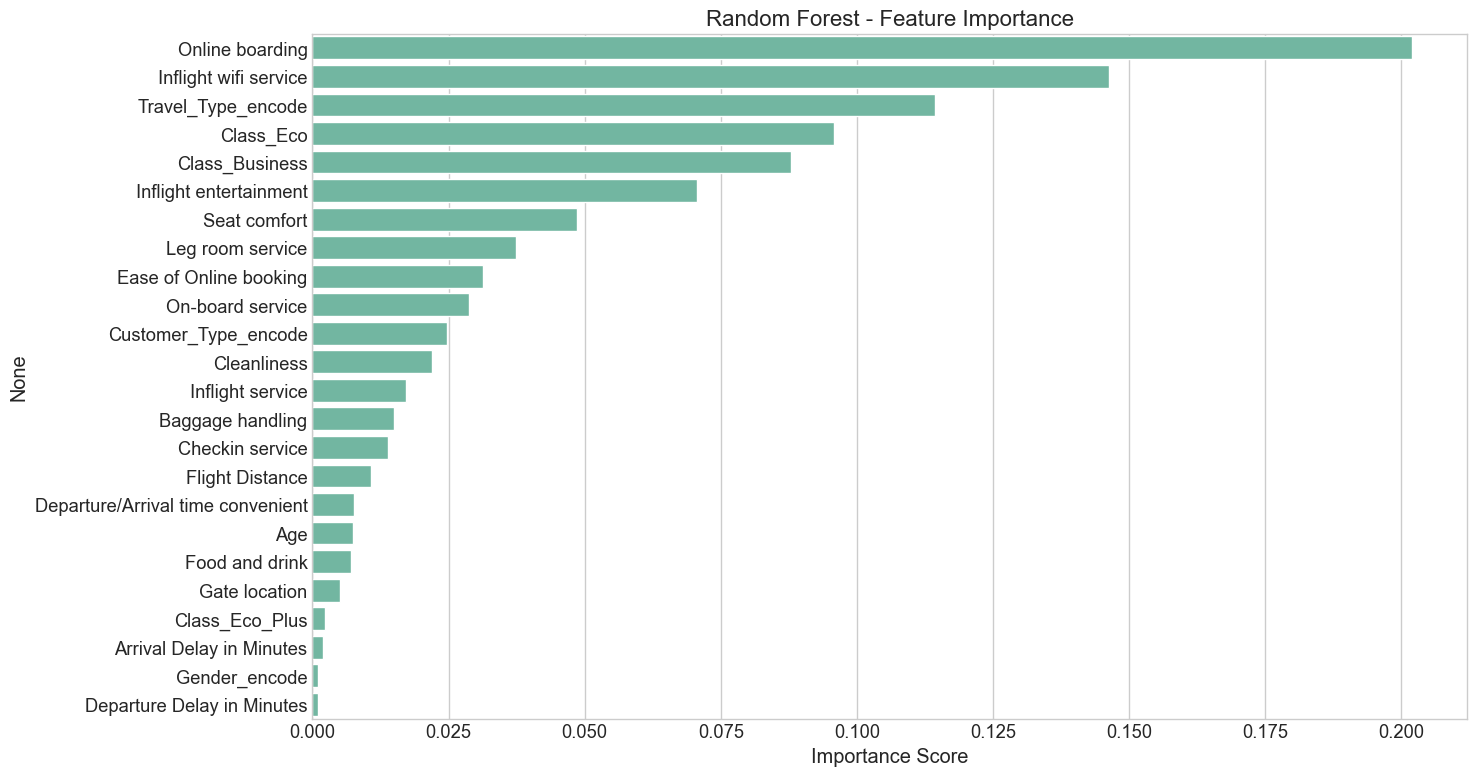

Top 10 most important features:
Online boarding           0.201898
Inflight wifi service     0.146206
Travel_Type_encode        0.114312
Class_Eco                 0.095701
Class_Business            0.087941
Inflight entertainment    0.070680
Seat comfort              0.048630
Leg room service          0.037391
Ease of Online booking    0.031396
On-board service          0.028831
dtype: float64


In [50]:
# Visualize feature importance for Random Forest
plt.figure(figsize=(15, 8))
importances = pd.Series(rf_model.feature_importances_, index=X_train[predictors].columns)
importances = importances.sort_values(ascending=False)

sns.barplot(x=importances.values, y=importances.index)
plt.title('Random Forest - Feature Importance', fontsize=16)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 most important features:")
print(importances[:10])

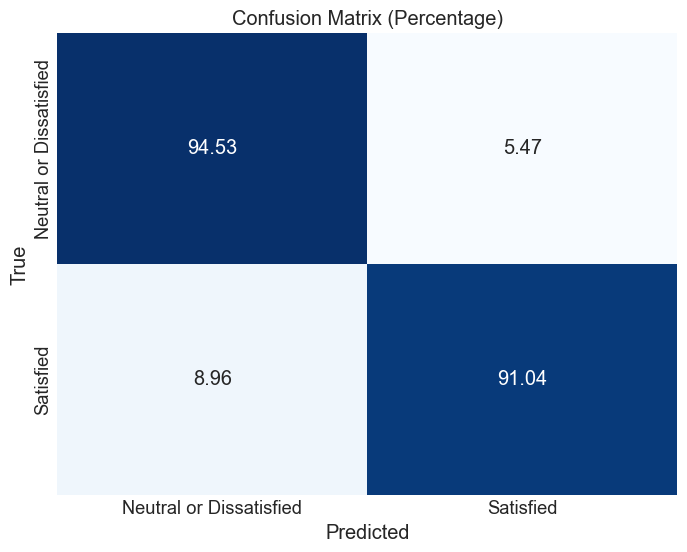

In [51]:
# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_rf)

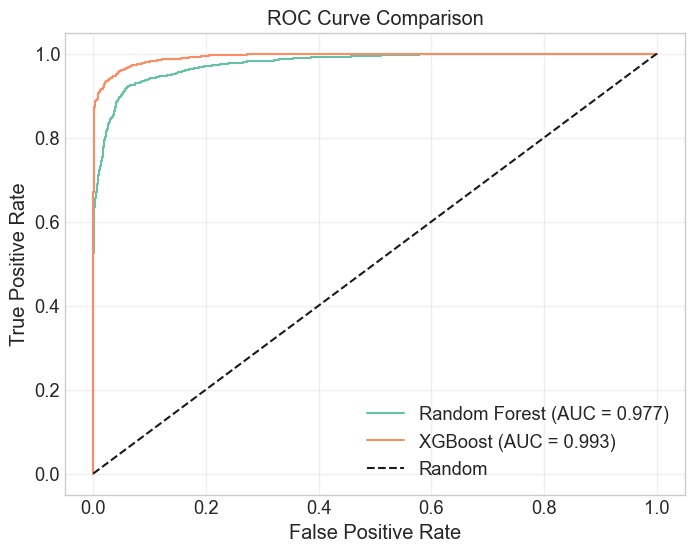

In [52]:
# Get probability predictions
y_pred_rf_proba = rf_model.predict_proba(X_test[predictors])[:, 1]

# Calculate ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

# Compare with XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob)
auc_xgb = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

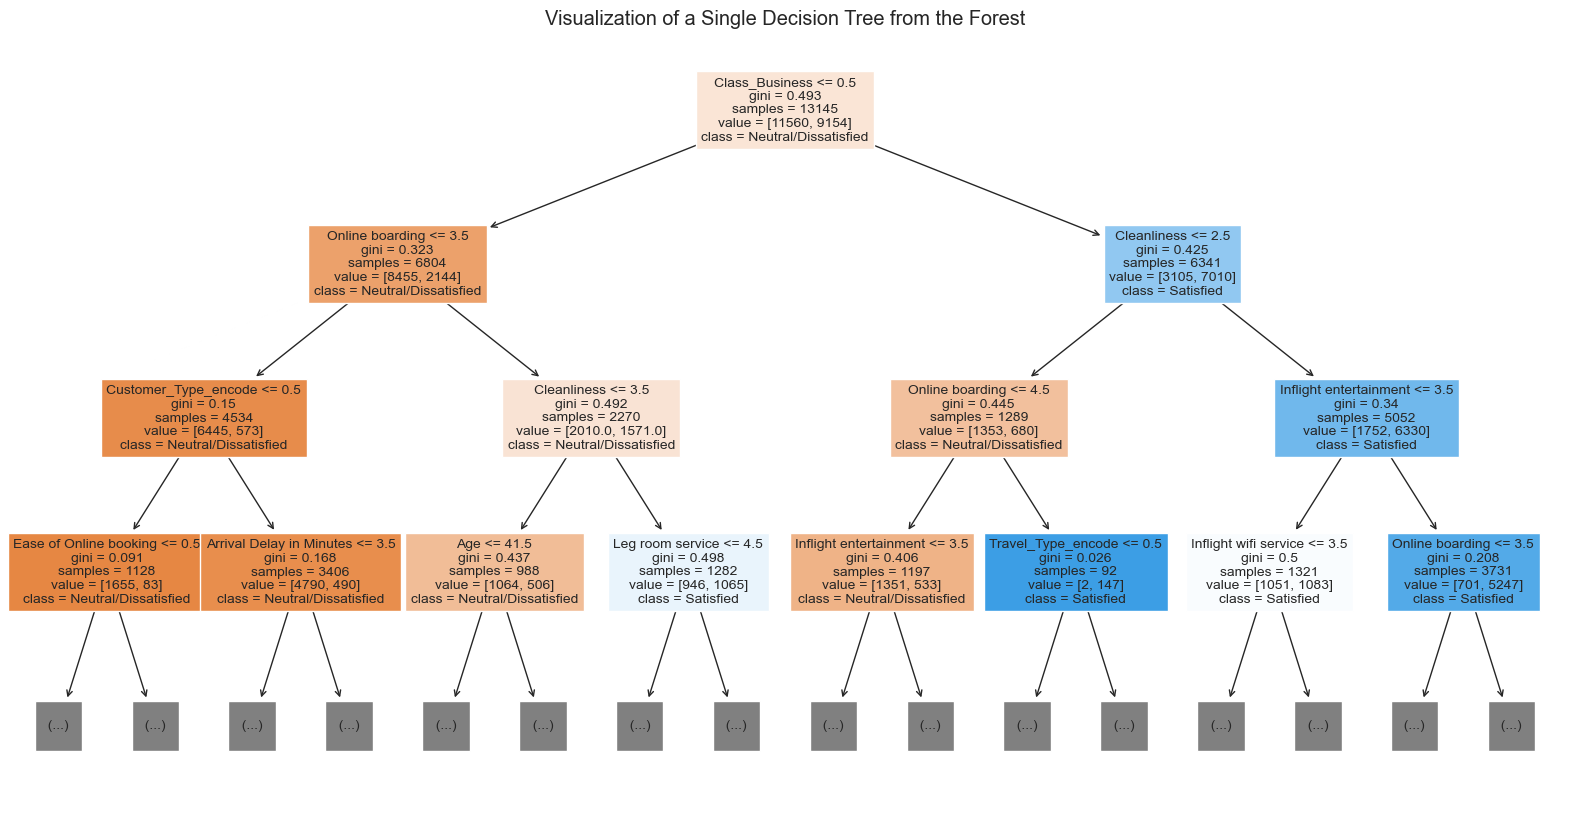

In [53]:
from sklearn.tree import plot_tree

# Visualize a single tree from the forest (e.g., the first tree)
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], 
          feature_names=predictors, 
          class_names=['Neutral/Dissatisfied', 'Satisfied'],
          filled=True, 
          max_depth=3,  # Limit depth for readability
          fontsize=10)
plt.title('Visualization of a Single Decision Tree from the Forest')
plt.show()

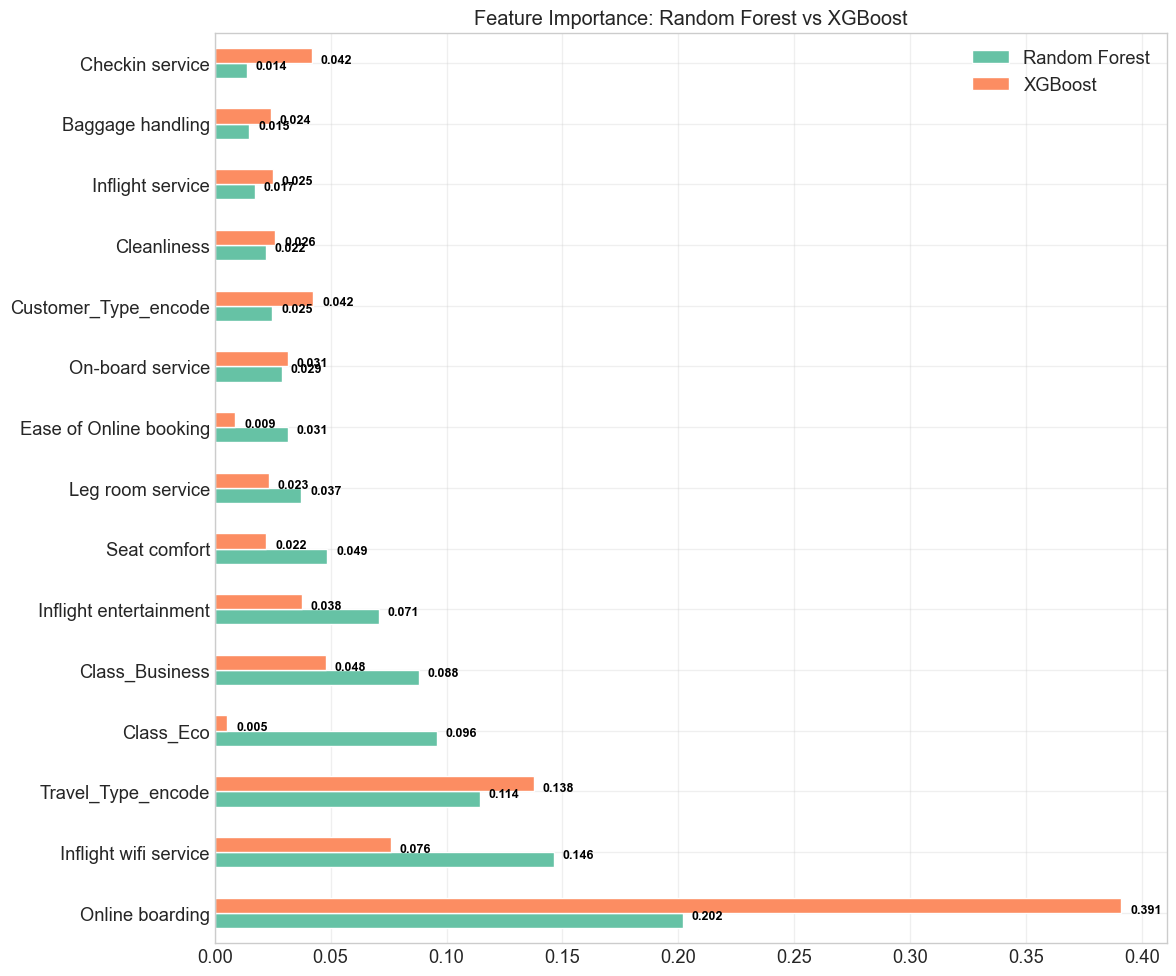

In [60]:
# Compare feature importance between Random Forest and XGBoost
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train[predictors].columns)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train[predictors].columns)

# Get top 15 features from each
top_features = pd.concat([rf_importances.rename('Random Forest'), 
                         xgb_importances.rename('XGBoost')], axis=1)
                         
top_features = top_features.sort_values('Random Forest', ascending=False).head(15)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 10))
top_features.plot(kind='barh', ax=ax)
plt.title('Feature Importance: Random Forest vs XGBoost')
plt.grid(alpha=0.3)

# Calculate offset based on maximum value for proper text positioning
max_val = top_features.values.max()
offset = max_val * 0.01

# Get the colors from the current plot
bars = ax.containers
colors = [bars[0].patches[0].get_facecolor(), bars[1].patches[0].get_facecolor()]

# Add text annotations with values
for i, (label, color) in enumerate(zip(['Random Forest', 'XGBoost'], colors)):
    for j, (idx, row) in enumerate(top_features.iterrows()):
        value = row[label]
        # Position text after the end of each bar
        ax.text(value + offset, j - 0.05 + i*0.1, f"{value:.3f}", 
                va='center', ha='left', fontsize=9, color='black',
                fontweight='bold')

plt.tight_layout()
plt.show()

## TabNet

In [93]:
# use the TabNet to predict the satisfaction of the passengers based on the splited dataset, use pytorch tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Set the device to GPU if available
device = torch.device(gpu_config["device"])

# Convert input data to float32 to avoid MPS float64 error
X_train_float32 = X_train[predictors].values.astype(np.float32)
X_test_float32 = X_test[predictors].values.astype(np.float32)

# Initialize the TabNet classifier
tabnet_model = TabNetClassifier(
    device_name=device,
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=0.001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',  # "sparsemax"
)

# Fit the model with float32 data
tabnet_model.fit(
    X_train_float32,
    y_train.values,
    eval_set=[(X_test_float32, y_test.values)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Make predictions with float32 data
y_pred_tabnet = tabnet_model.predict(X_test_float32)



/opt/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.50975 | test_accuracy: 0.52443 |  0:00:01s
epoch 1  | loss: 0.36326 | test_accuracy: 0.59027 |  0:00:03s
epoch 2  | loss: 0.34383 | test_accuracy: 0.64993 |  0:00:04s
epoch 3  | loss: 0.3423  | test_accuracy: 0.68198 |  0:00:05s
epoch 4  | loss: 0.32887 | test_accuracy: 0.7094  |  0:00:07s
epoch 5  | loss: 0.32193 | test_accuracy: 0.81348 |  0:00:08s
epoch 6  | loss: 0.30447 | test_accuracy: 0.83163 |  0:00:10s
epoch 7  | loss: 0.28806 | test_accuracy: 0.85267 |  0:00:11s
epoch 8  | loss: 0.26628 | test_accuracy: 0.86542 |  0:00:13s
epoch 9  | loss: 0.24537 | test_accuracy: 0.88048 |  0:00:14s
epoch 10 | loss: 0.23624 | test_accuracy: 0.88453 |  0:00:16s
epoch 11 | loss: 0.23984 | test_accuracy: 0.88395 |  0:00:17s
epoch 12 | loss: 0.22551 | test_accuracy: 0.89052 |  0:00:18s
epoch 13 | loss: 0.20863 | test_accuracy: 0.89399 |  0:00:20s
epoch 14 | loss: 0.20351 | test_accuracy: 0.91408 |  0:00:22s
epoch 15 | loss: 0.19868 | test_accuracy: 0.91755 |  0:00:23s
epoch 16

/opt/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Accuracy: 0.9513


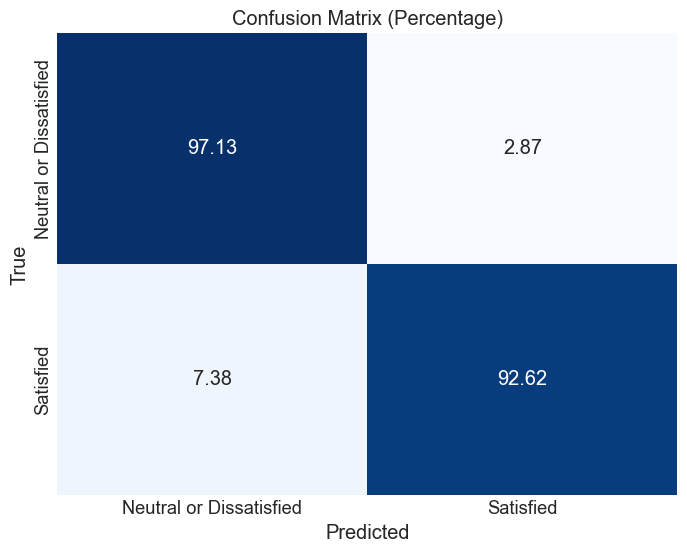

In [94]:
# Evaluate the model
accuracy_tabnet = accuracy_score(y_test, y_pred_tabnet)
print(f"TabNet Accuracy: {accuracy_tabnet:.4f}")
# Plot confusion matrix for TabNet
plot_confusion_matrix(y_test, y_pred_tabnet)

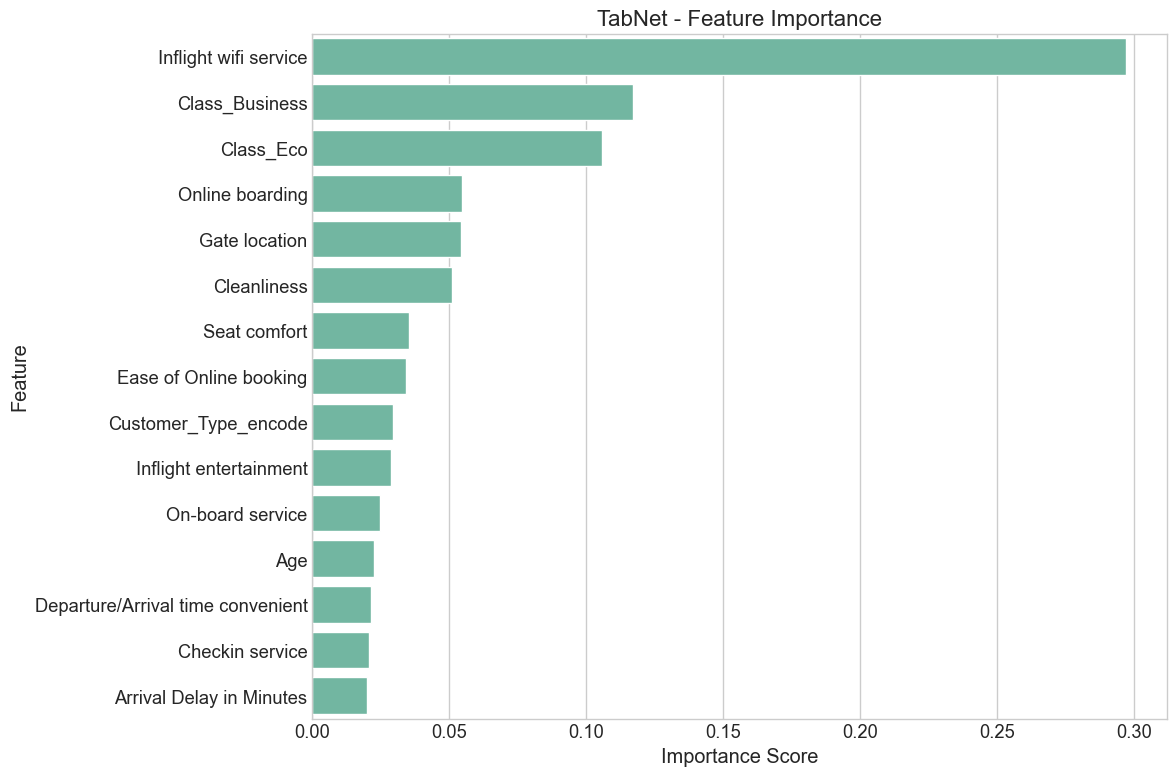

In [95]:
# Feature importance plot for TabNet
plt.figure(figsize=(12, 8))
feature_importances = tabnet_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train[predictors].columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('TabNet - Feature Importance', fontsize=16)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

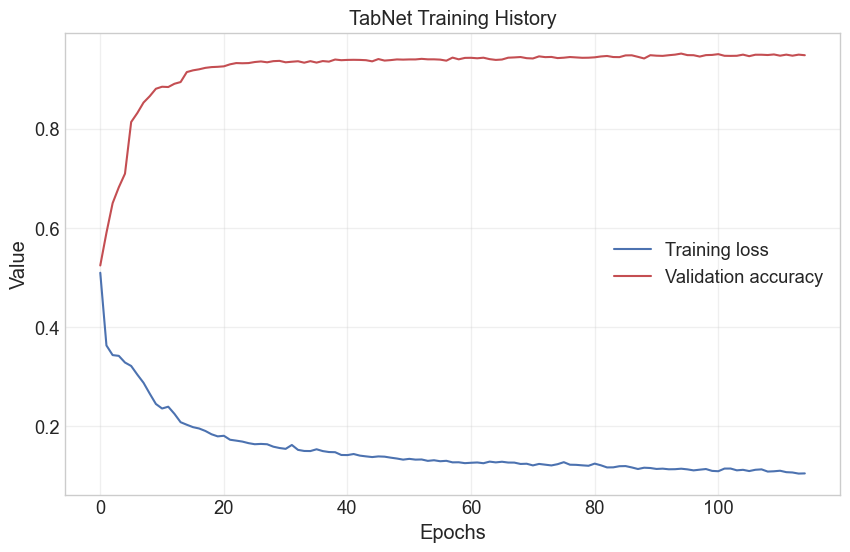

In [96]:
# Learning curves (training history)
plt.figure(figsize=(10, 6))
history = tabnet_model.history['loss']
val_metrics = tabnet_model.history['test_accuracy']
epochs = range(len(history))

plt.plot(epochs, history, 'b', label='Training loss')
plt.plot(epochs, val_metrics, 'r', label='Validation accuracy')
plt.title('TabNet Training History')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

/var/folders/hv/1ymrtwbx65590wt4nm4gwphw0000gn/T/ipykernel_66313/2019148729.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


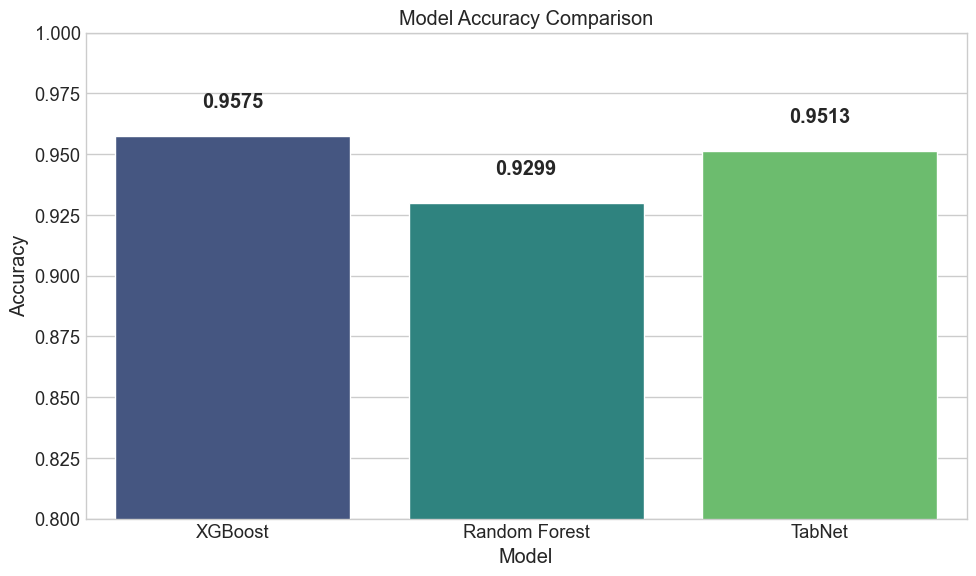

In [97]:
# Model performance comparison
models = ['XGBoost', 'Random Forest', 'TabNet']
accuracies = [accuracy, accuracy_rf, accuracy_tabnet]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Adjust based on your actual values
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.01, f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

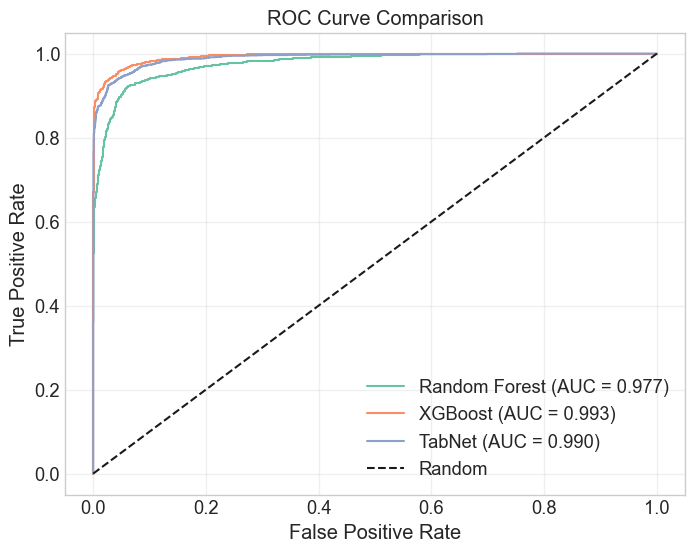

In [98]:
# Compare ROC curves for all three models
plt.figure(figsize=(8, 6))

# Get probability predictions for TabNet
y_pred_tabnet_proba = tabnet_model.predict_proba(X_test_float32)[:, 1]
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test, y_pred_tabnet_proba)
auc_tabnet = roc_auc_score(y_test, y_pred_tabnet_proba)

# Plot ROC curves
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_tabnet, tpr_tabnet, label=f'TabNet (AUC = {auc_tabnet:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## NODE

In [84]:
import torch
from pytorch_node.node import NodeClassifier

ModuleNotFoundError: No module named 'pytorch_node'

## FT-Transformer

In [89]:
from rtdl import FTTransformer
import torch

In [90]:
# Create PyTorch datasets and dataloaders
from torch.utils.data import TensorDataset, DataLoader

In [92]:
# Prepare data - convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train[predictors].values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test[predictors].values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)